 # Notebook: Construcción de un Modelo Lineal con Scikit-learn



 En este notebook, seguiremos un flujo de trabajo de Machine Learning para construir un modelo de regresión lineal. Seremos "rigurosos" al no asumir que los datos están limpios.



 Usaremos `sklearn` para todo el proceso, incluyendo:

 1.  Carga y Análisis Exploratorio de Datos (EDA).

 2.  Creación de un *Pipeline* de Preprocesamiento (`ColumnTransformer`).

 3.  Manejo de datos faltantes (`SimpleImputer`).

 4.  Manejo de datos categóricos (`OneHotEncoder`).

 5.  Entrenamiento de un modelo base.

 6.  Diagnóstico del modelo (Overfitting) usando características polinómicas.

 7.  **Solución 1: Regularización (Ridge, Lasso, Elastic-Net).**

 8.  **Solución 2: Sintonización de Hiperparámetros (CV y GridSearch).**

 9.  **Solución 3: Selección de Variables (Stepwise).**

 10. Comparación final de todos los modelos.



 ## El Problema: Predecir la Eficiencia de Combustible (MPG)



 Usaremos el dataset "Auto MPG". La meta es predecir las "millas por galón" (`mpg`) de un auto basándonos en sus características (`cylinders`, `weight`, `horsepower`, etc.).



 Este dataset es ideal porque requiere limpieza:

 * `horsepower` (caballos de fuerza) tiene valores faltantes.

 * `origin` (país de origen) es una variable categórica codificada como número.

 ## 1. Configuración Inicial e Importaciones

In [37]:
# Importaciones principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos Lineales
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeCV,
    LassoCV,
    ElasticNetCV
)

# Selección de variables y Sintonización
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

# Métricas y Visualización
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

# Configuración de visualización
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)


 ## 2. Carga y Análisis Exploratorio de Datos (EDA)

In [38]:
# Cargar el dataset directamente desde Seaborn (alternativa a UCI)
try:
    df = sns.load_dataset('mpg')
    print("Dataset 'mpg' cargado exitosamente.")
except Exception as e:
    print(f"Error cargando el dataset: {e}")
    print("Intentando cargar desde UCI...")
    # URL del dataset original
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    # Nombres de las columnas
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                    'acceleration', 'model_year', 'origin', 'name']
    # Leer los datos, especificando el separador (espacio) y los valores faltantes (?)
    df = pd.read_csv(url, names=column_names, delim_whitespace=True, na_values="?")


print(f"Tamaño del dataset: {df.shape}")
df.head()


Dataset 'mpg' cargado exitosamente.
Tamaño del dataset: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


 ### 2.1. Limpieza Inicial y Tipos de Datos



 `origin` es categórico, pero está como número. Lo mapeamos a strings para que sea explícito.

 `horsepower` tiene valores faltantes (NaN).

 Mapeo de 'origin' a nombres legibles

 Revisión de tipos de datos y valores faltantes

 ### 2.2. Correlograma (Heatmap)



 Buscamos correlaciones altas entre variables predictoras (multicolinealidad) y entre predictoras y la variable objetivo (`mpg`).

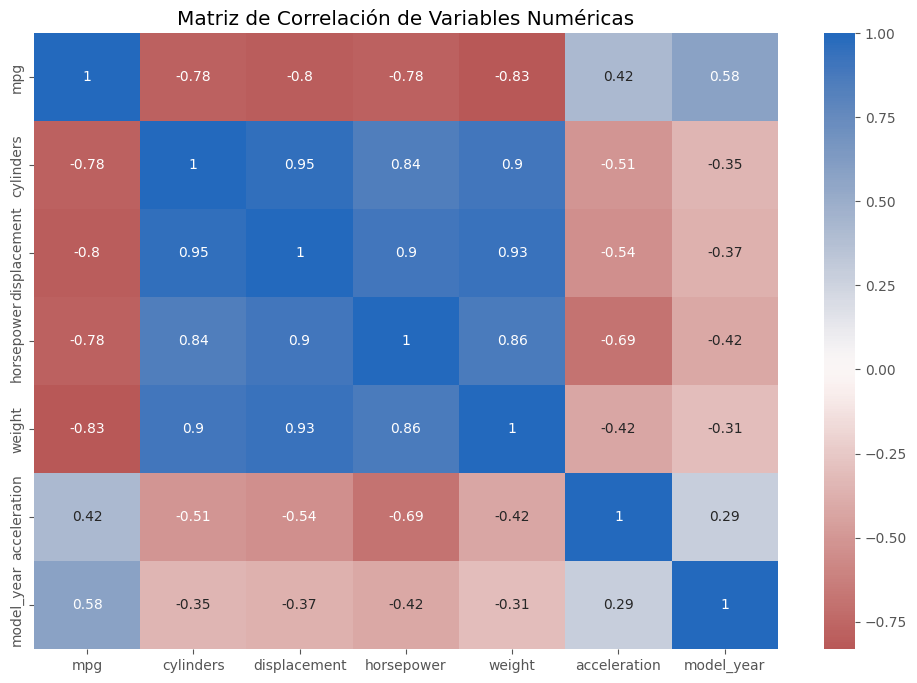

In [39]:
# Seleccionamos solo columnas numéricas para el heatmap
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='vlag_r', center=0)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()


 **Análisis del Correlograma:**

 * **Correlación Fuerte con `mpg` (Objetivo):** `weight`, `displacement`, `horsepower` y `cylinders` tienen una correlación negativa muy fuerte con `mpg`. Esto es lógico: autos más pesados y potentes consumen más combustible (menos mpg).

 * **Multicolinealidad (Problema):** Vemos correlaciones extremadamente altas entre `cylinders`, `displacement`, `horsepower` y `weight`. Esto puede desestabilizar los coeficientes de un modelo lineal simple.

 ### 2.3. Análisis Visual (Pairplot)



 Visualizamos las relaciones entre las variables.

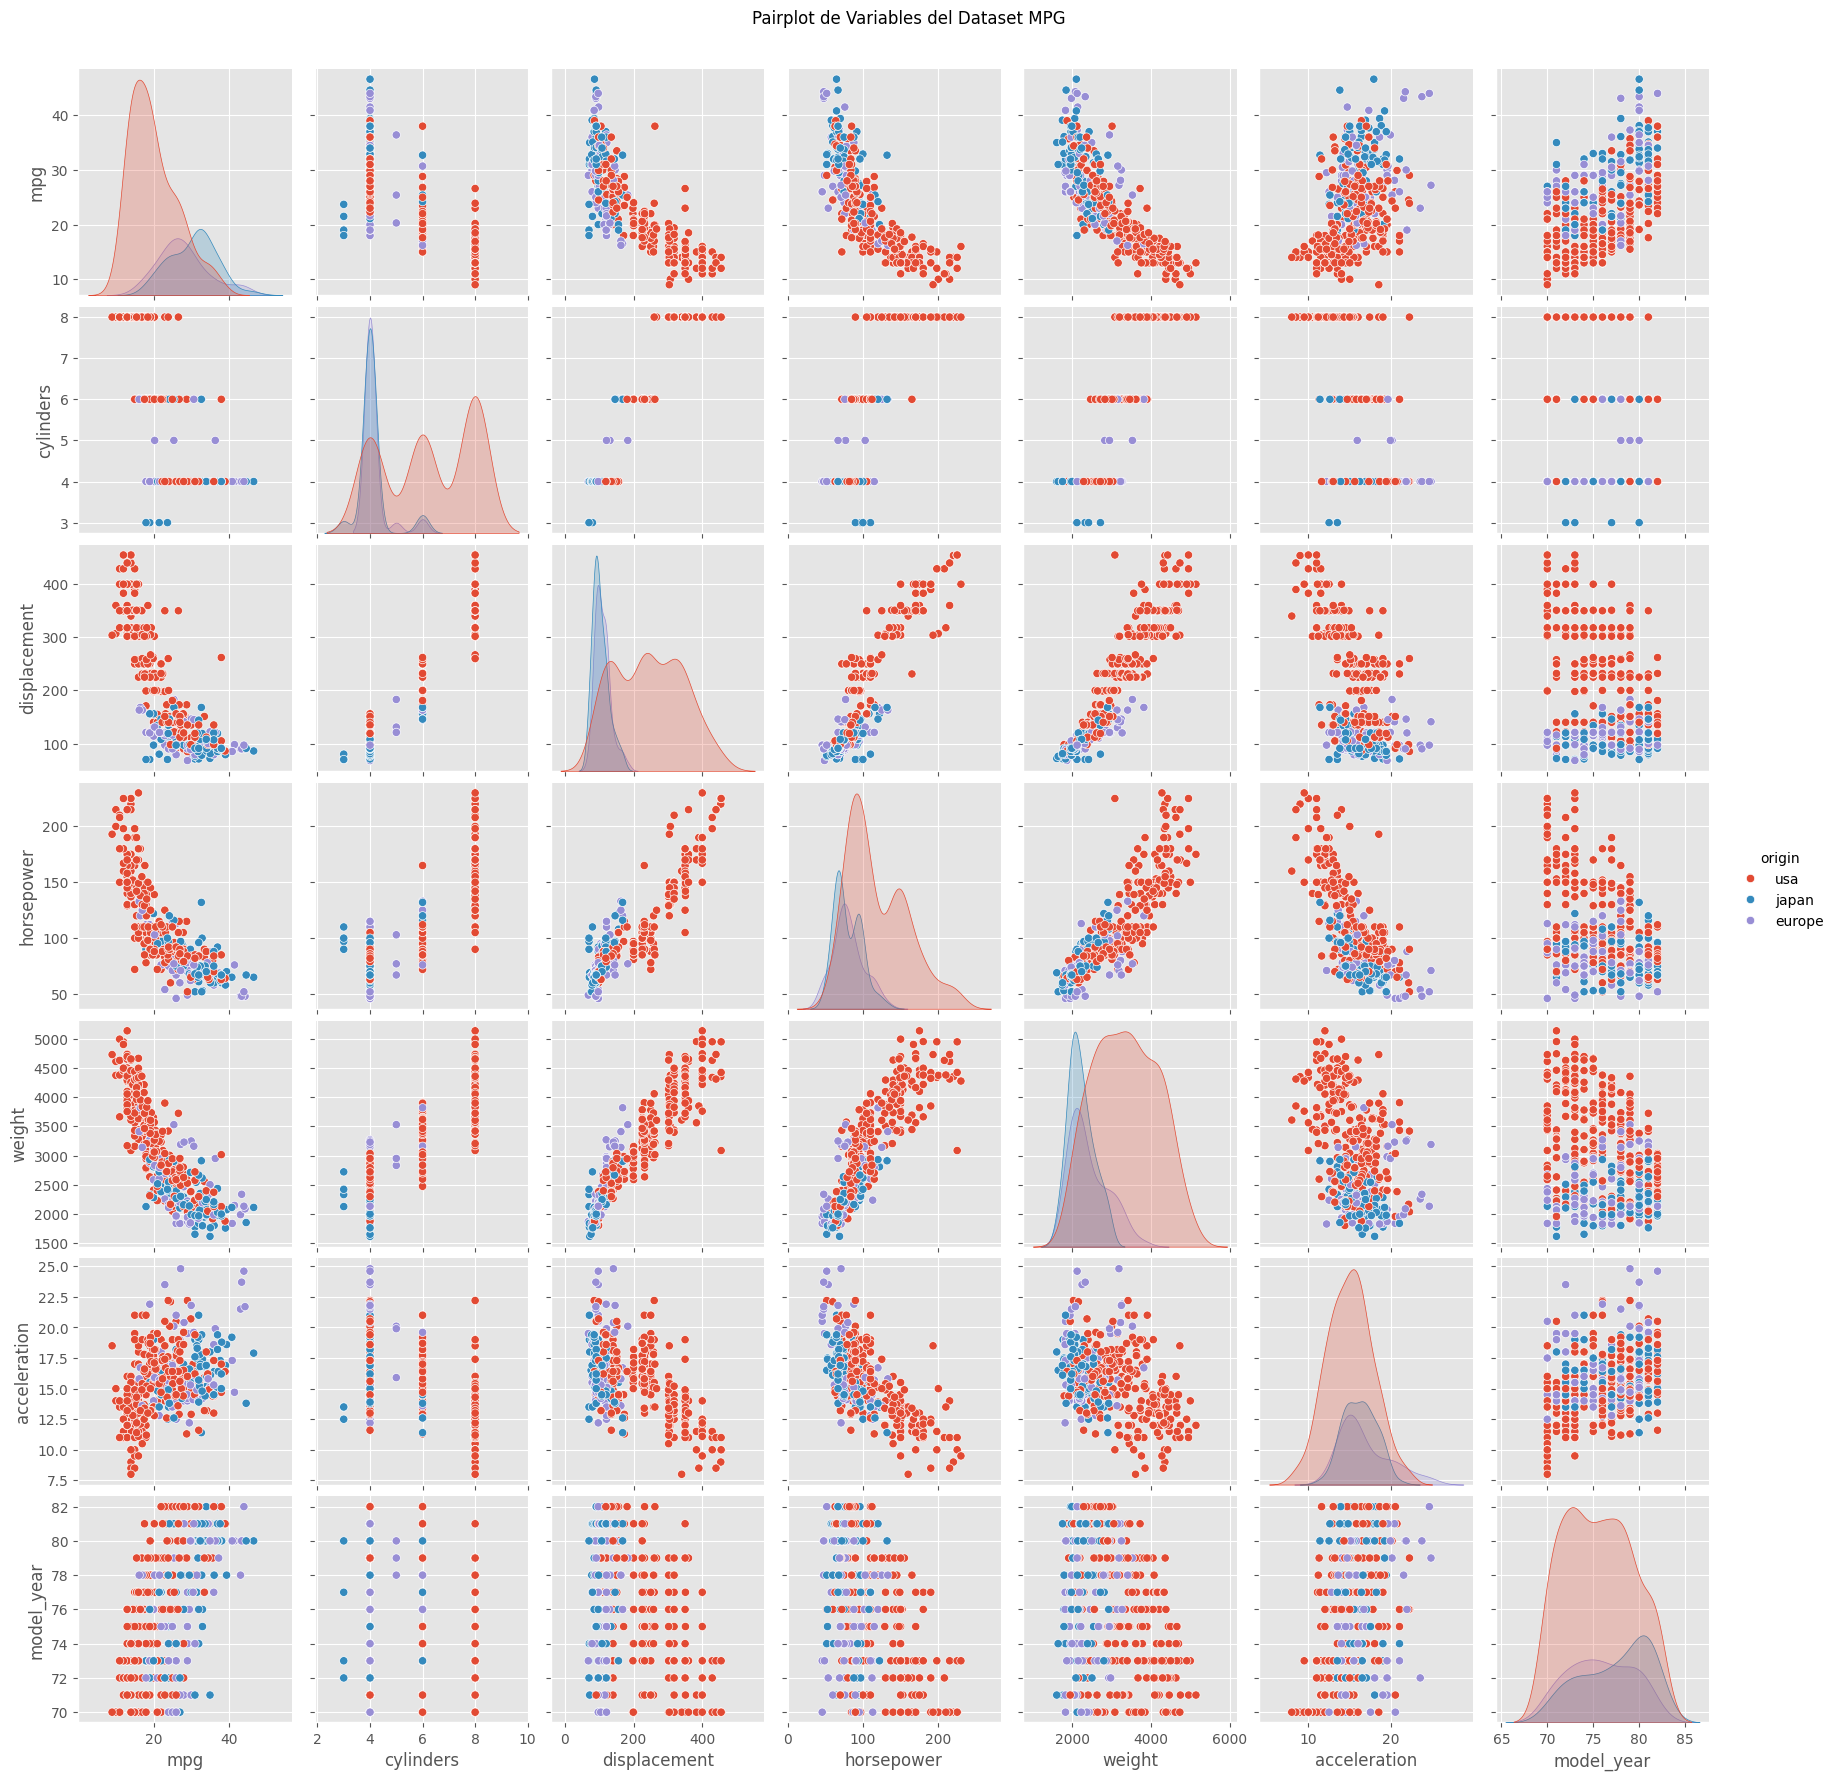

In [40]:
# Usamos 'origin' para colorear los puntos
# 'name' no es relevante para el pairplot y puede no existir
df = df.drop(columns=['name'])
sns.pairplot(df, hue='origin', diag_kind='kde')
plt.suptitle("Pairplot de Variables del Dataset MPG", y=1.02)
plt.show()


 **Análisis del Pairplot:**

 1.  **Relaciones No Lineales:** La relación entre `mpg` y variables como `weight` o `horsepower` no es una línea recta perfecta, tiene una curva. Esto sugiere que un modelo lineal simple podría mejorar.

 2.  **`origin` Importa:** Los autos de 'USA' (azules) tienden a agruparse en la zona de mayor peso/potencia y menor `mpg`. 'Japan' (verde) está en el extremo opuesto. `origin` es claramente una variable predictiva importante.

 ## 3. Definición del Pipeline de Preprocesamiento



 Este es el paso más crítico en `sklearn`. Usamos un `ColumnTransformer` para aplicar diferentes transformaciones a diferentes columnas.



 1.  **Pipeline Numérico:**

     * `SimpleImputer`: Rellena los `NaN` en `horsepower` con la media.

     * `StandardScaler`: Escala todas las variables numéricas (fundamental para la regularización).

 2.  **Pipeline Categórico:**

     * `OneHotEncoder`: Convierte `origin` ('USA', 'Europe', 'Japan') en 3 columnas binarias (0/1).



 ### 3.1. División de Datos (Train/Test)



 Primero, separamos los datos para evitar "fuga de datos" (data leakage). El preprocesamiento se *aprende* en `X_train` y solo se *aplica* a `X_test`.

In [41]:
X = df.drop(columns=['mpg'])
y = df['mpg']

# Dividimos 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de Entrenamiento: {X_train.shape}")
print(f"Tamaño de Prueba: {X_test.shape}")


Tamaño de Entrenamiento: (318, 7)
Tamaño de Prueba: (80, 7)


In [42]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
3,8,304.0,150.0,3433,12.0,70,usa
18,4,97.0,88.0,2130,14.5,70,japan
376,4,91.0,68.0,2025,18.2,82,japan
248,4,91.0,60.0,1800,16.4,78,japan
177,4,115.0,95.0,2694,15.0,75,europe


 ### 3.2. Creación de los Pipelines

In [43]:
# 1. Definir las listas de columnas
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"Columnas numéricas: {numeric_features}")
print(f"Columnas categóricas: {categorical_features}")

# 2. Crear el pipeline para variables numéricas
#    - Paso 1: Imputar valores faltantes (NaN) con la media
#    - Paso 2: Escalar los datos (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 3. Crear el pipeline para variables categóricas
#    - Paso 1: Convertir a One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combinar ambos pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)


Columnas numéricas: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
Columnas categóricas: ['origin']


 ## 4. Modelo Base: Regresión Lineal Simple



 Nuestro primer modelo será una Regresión Lineal estándar (`LinearRegression`) conectada a nuestro preprocesador.

In [71]:
# Creamos el pipeline final que incluye el preprocesamiento Y el modelo
model_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Entrenamos el modelo
model_pipeline_base.fit(X_train, y_train)

# Predecimos en el set de prueba
y_pred_base_train = model_pipeline_base.predict(X_train)
y_pred_base = model_pipeline_base.predict(X_test)

# Calculamos el RMSE (Root Mean Squared Error)
# Usamos np.sqrt() porque mean_squared_error da el MSE
rmse_base_train = np.sqrt(mean_squared_error(y_train, y_pred_base_train))
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

print(f"RMSE del Modelo Base: {rmse_base_train:.4f}")
print(f"RMSE del Modelo Base: {rmse_base:.4f}")

# Lista para guardar los resultados de todos los modelos
results = []
results.append({'Modelo': '1. Lineal Base', 'RMSE_Test': rmse_base})


RMSE del Modelo Base: 3.3702
RMSE del Modelo Base: 2.8877


 ### 4.1. Diagnóstico del Modelo Base



 Un RMSE de ~2.88 mpg no está mal, pero veamos los residuales.

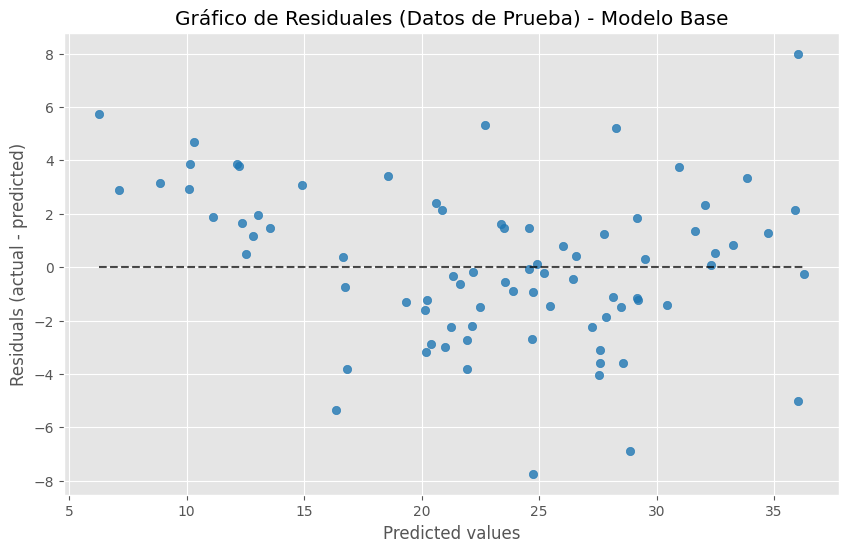

In [45]:
# Gráfico de Residuales vs. Predicciones
# Idealmente, queremos ver una nube de puntos aleatoria centrada en 0, sin patrones.
fig, ax = plt.subplots(figsize=(10, 6))

PredictionErrorDisplay.from_estimator(model_pipeline_base, X_test, y_test, kind='residual_vs_predicted', ax=ax)
ax.set_title("Gráfico de Residuales (Datos de Prueba) - Modelo Base")
plt.show()


 **Análisis de Residuales:** Los residuales no están perfectamente aleatorios. Parecen formar una ligera curva (forma de 'U' o sonrisa), lo que confirma nuestra sospecha del pairplot: la relación no es puramente lineal.

 ## 5. El Problema: Creando Overfitting



 ¿Cómo podemos capturar la "curva" que vimos? Usando `PolynomialFeatures`.



 Pero esto es peligroso. Un polinomio de grado alto (ej. grado 3) creará muchísimas variables nuevas (interacciones como $peso \times potencia$, $peso^2$, $potencia^3$, etc.), llevando a un **sobreajuste (overfitting)**.



 **Overfitting:** El modelo memoriza los datos de entrenamiento (RMSE de entrenamiento muy bajo) pero falla miserablemente al predecir datos nuevos (RMSE de prueba muy alto).

In [69]:
# Definimos un pipeline polinómico
pipe_poly_overfit = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', LinearRegression())
])

# Entrenamos el modelo sobreajustado
pipe_poly_overfit.fit(X_train, y_train)

# Evaluamos en Train
y_pred_poly_overfit_train = pipe_poly_overfit.predict(X_train)
rmse_poly_overfit_train = np.sqrt(mean_squared_error(y_train, y_pred_poly_overfit_train))

print(f"RMSE Modelo Polinómico (Grado 5) en Train: {rmse_poly_overfit_train:.4f}")

# Evaluamos en Test
y_pred_poly_overfit = pipe_poly_overfit.predict(X_test)
rmse_poly_overfit = np.sqrt(mean_squared_error(y_test, y_pred_poly_overfit))


print(f"RMSE Modelo Polinómico (Grado 5) en Test: {rmse_poly_overfit:.4f}")
results.append({'Modelo': '2. Polinómico (Overfit)', 'RMSE_Test': rmse_poly_overfit})


RMSE Modelo Polinómico (Grado 5) en Train: 0.0000
RMSE Modelo Polinómico (Grado 5) en Test: 80.9767


In [64]:
pipe_poly_overfit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cylinders', 'displacement',
                                                   'horsepower', 'weight',
                                                   'acceleration',
                                                   'model_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['origin'])])),
                ('poly_features',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('model', LinearRegression())])

 **¡Desastre!** Nuestro RMSE en test subió de 2.88 a 80.97. Esto es un overfitting clásico. El modelo es demasiado complejo y los coeficientes han "explotado".

 ## 6. Solución 1: Regularización (El "Freno")



 La regularización añade una penalización al modelo por tener coeficientes (parámetros $\beta$) demasiado grandes. Esto "doma" el modelo polinómico y previene el overfitting.



 * **Ridge (L2):** Penaliza la *suma de los cuadrados* de los coeficientes. Encoge los coeficientes, pero no los elimina.

 * **Lasso (L1):** Penaliza la *suma de los valores absolutos*. Puede encoger coeficientes hasta exactamente 0 (haciendo selección de variables).



 ### 6.1. Arreglo Rápido: Ridge (L2)



 Reemplazamos `LinearRegression` con `Ridge`. `alpha` controla la fuerza de la penalización.

In [73]:
# Mismo pipeline polinómico, pero con Ridge(alpha=10)
pipe_poly_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', Ridge(alpha=10.0)) # alpha=fuerza de regularización
])

pipe_poly_ridge.fit(X_train, y_train)

y_pred_ridge_train = pipe_poly_ridge.predict(X_train)
y_pred_ridge = pipe_poly_ridge.predict(X_test)

rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"RMSE Train Polinómico + Ridge (alpha=10): {rmse_ridge_train:.4f}")
print(f"RMSE Test  Polinómico + Ridge (alpha=10): {rmse_ridge:.4f}")
results.append({'Modelo': '3. Ridge (Simple)', 'RMSE_Test': rmse_ridge})


RMSE Train Polinómico + Ridge (alpha=10): 1.5434
RMSE Test  Polinómico + Ridge (alpha=10): 3.5560


 ### 6.2. Arreglo Rápido: Lasso (L1)



 Reemplazamos `LinearRegression` con `Lasso`.

In [75]:
# Mismo pipeline polinómico, pero con Lasso(alpha=0.1)
pipe_poly_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', Lasso(alpha=0.1, max_iter=2000)) # Lasso necesita más iteraciones
])

pipe_poly_lasso.fit(X_train, y_train)

y_pred_lasso_train = pipe_poly_lasso.predict(X_train)
rmse_lasso_train = np.sqrt(mean_squared_error(y_train, y_pred_lasso_train))

y_pred_lasso = pipe_poly_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"RMSE train Polinómico + Lasso (alpha=0.1): {rmse_lasso_train:.4f}")
print(f"RMSE test Polinómico + Lasso (alpha=0.1): {rmse_lasso:.4f}")
results.append({'Modelo': '4. Lasso (Simple)', 'RMSE_Test': rmse_lasso})


RMSE train Polinómico + Lasso (alpha=0.1): 2.3743
RMSE test Polinómico + Lasso (alpha=0.1): 2.5869


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+01, tolerance: 1.994e+00
  model = cd_fast.enet_coordinate_descent(


 **¡Éxito!** Simplemente añadiendo `Ridge` o `Lasso`, nuestro RMSE bajó de 80.97 a ~2.5.



 La regularización *controló* el modelo polinómico, permitiéndonos capturar la no linealidad (la curva) sin sobreajustar.

 ## 7. Solución 2: El "Mejor" de los Dos Mundos: Elastic-Net



 **Elastic-Net** es una combinación de Ridge (L2) y Lasso (L1).



 * Toma lo mejor de **Lasso**: Puede seleccionar variables (llevar coeficientes a cero).

 * Toma lo mejor de **Ridge**: Es muy estable y bueno manejando variables correlacionadas (¡como las que vimos en el heatmap!).



 Tiene dos hiperparámetros:

 1.  `alpha`: La fuerza *total* de la regularización.

 2.  `l1_ratio`: La *mezcla* (0.0 = Ridge puro, 1.0 = Lasso puro, 0.5 = 50/50).

 ### 7.1. Visualización: El "Camino" de los Coeficientes (Coefficient Paths)



 Veamos *cómo* Lasso y ElasticNet encogen los coeficientes a medida que `alpha` (la penalización) aumenta.



 Para esto, debemos aplicar el preprocesador y el polinomio *antes* de pasarlo al modelo.

In [49]:
# 1. Creamos el preprocesador polinómico completo
poly_preprocessor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False))
])

# 2. Transformamos los datos de entrenamiento
X_train_processed = poly_preprocessor.fit_transform(X_train)

# 3. Obtenemos los nombres de todas las nuevas características
# (Esto es complejo, pero útil para la visualización)
try:
    poly_feature_names = poly_preprocessor.named_steps['poly_features'].get_feature_names_out(X.columns)
    final_feature_names = poly_preprocessor.named_steps['preprocessor'].get_feature_names_out(poly_feature_names)
except:
    # Fallback para versiones antiguas de sklearn
    final_feature_names = [f"feat_{i}" for i in range(X_train_processed.shape[1])]


print(f"Número de características polinómicas (Grado 5): {X_train_processed.shape[1]}")


Número de características polinómicas (Grado 5): 2001


In [62]:
# 4. Entrenamos un LassoCV para obtener el "camino"
# eps, n_alphas controlan la granularidad del gráfico
alphas_lasso, coefs_lasso, _ = Lasso.path(X_train_processed, y_train, n_alphas=100, max_iter=5000)

# 5. Entrenamos un ElasticNetCV para obtener el "camino"
alphas_enet, coefs_enet, _ = ElasticNet.path(X_train_processed, y_train, l1_ratio=0.2, n_alphas=100, max_iter=5000)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.034e+01, tolerance: 1.972e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.143e+01, tolerance: 1.972e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.986e+01, tolerance: 1.972e

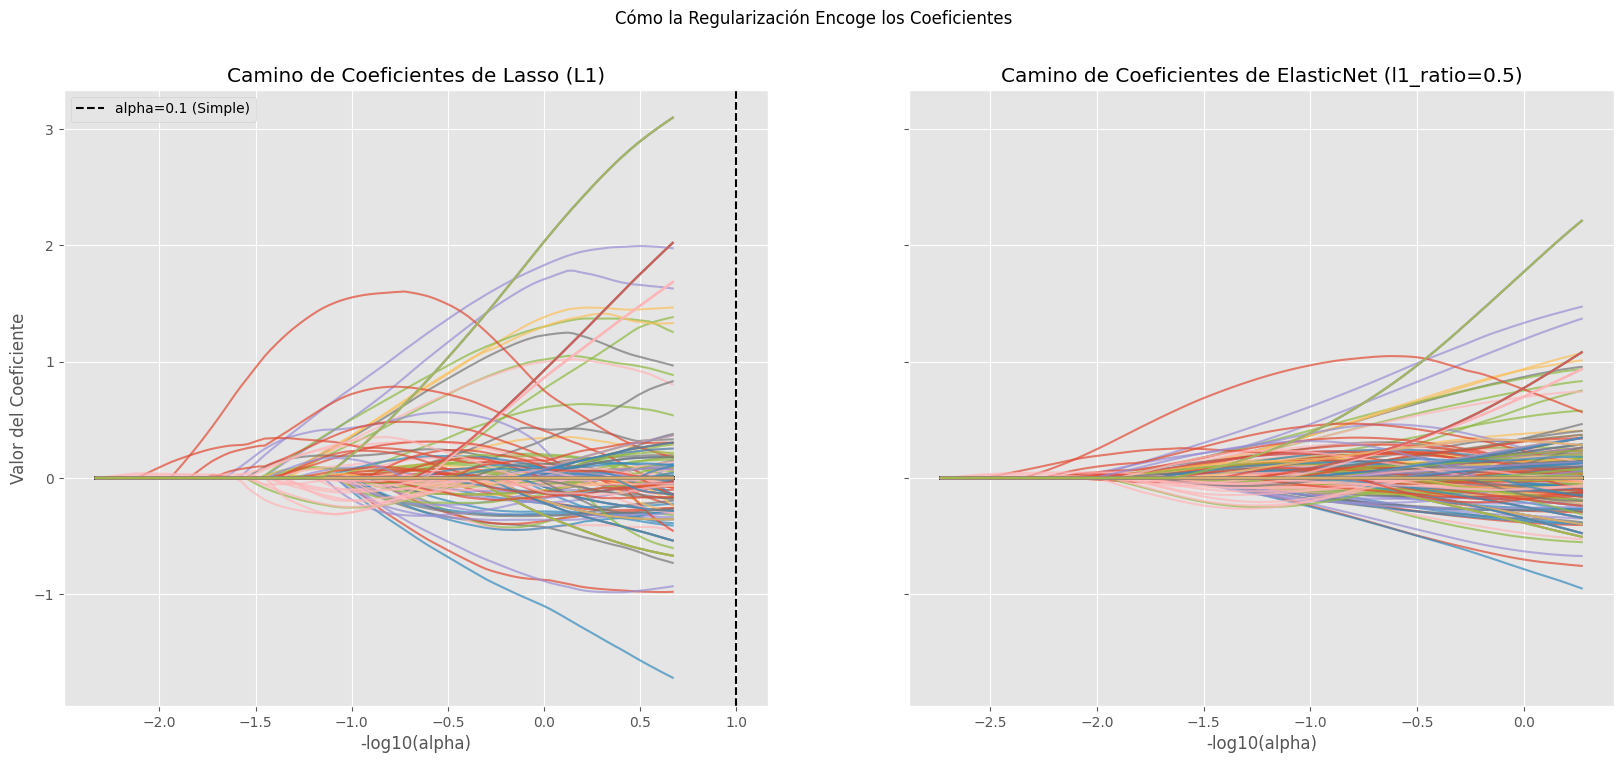

In [63]:
# 6. Graficamos los caminos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Gráfico de Lasso
for coef in coefs_lasso:
    ax1.plot(-np.log10(alphas_lasso), coef, alpha=0.7)
ax1.set_xlabel("-log10(alpha)")
ax1.set_ylabel("Valor del Coeficiente")
ax1.set_title("Camino de Coeficientes de Lasso (L1)")
ax1.axvline(-np.log10(0.1), linestyle='--', color='k', label='alpha=0.1 (Simple)') # Nuestro alpha manual
ax1.legend()

# Gráfico de ElasticNet
for coef in coefs_enet:
    ax2.plot(-np.log10(alphas_enet), coef, alpha=0.7)
ax2.set_xlabel("-log10(alpha)")
ax2.set_title("Camino de Coeficientes de ElasticNet (l1_ratio=0.5)")

plt.suptitle("Cómo la Regularización Encoge los Coeficientes")
plt.show()


 **Análisis de los Gráficos:**

 * A la izquierda (alpha bajo, -log(alpha) alto), los coeficientes son enormes (overfitting).

 * A medida que nos movemos a la derecha, `alpha` aumenta y la penalización "encoge" los coeficientes.

 * **Lasso (izquierda):** Los coeficientes colapsan a CERO uno por uno. ¡Esto es selección de variables!

 * **ElasticNet (derecha):** Los coeficientes se encogen más suavemente (por la influencia de Ridge), pero eventually también van a cero.

 ## 8. Solución 3: Sintonización Automática con Cross-Validation



 Elegimos `alpha=10` y `alpha=0.1` manualmente, pero ¿cuál es el *mejor* valor?



 Dejamos que `sklearn` lo encuentre usando Validación Cruzada (CV).



 * `RidgeCV`, `LassoCV`, `ElasticNetCV`: Son modelos que automáticamente prueban muchos alphas y eligen el mejor.

 ### 8.1. RidgeCV

In [52]:
# Pipeline con RidgeCV
# Probará 100 alphas entre 0.001 y 100
alphas_to_try = np.logspace(-3, 2, 100)

pipe_poly_ridge_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', RidgeCV(alphas=alphas_to_try, store_cv_values=True))
])

pipe_poly_ridge_cv.fit(X_train, y_train)
y_pred_ridge_cv = pipe_poly_ridge_cv.predict(X_test)

rmse_ridge_cv = np.sqrt(mean_squared_error(y_test, y_pred_ridge_cv))
best_alpha_ridge = pipe_poly_ridge_cv.named_steps['model'].alpha_

print(f"RMSE Polinómico + RidgeCV: {rmse_ridge_cv:.4f}")
print(f"Mejor alpha encontrado para Ridge: {best_alpha_ridge:.4f}")
results.append({'Modelo': '5. Ridge (CV)', 'RMSE_Test': rmse_ridge_cv})


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RMSE Polinómico + RidgeCV: 2.4127
Mejor alpha encontrado para Ridge: 35.1119


 ### 8.2. LassoCV

In [53]:
# Pipeline con LassoCV
pipe_poly_lasso_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', LassoCV(n_alphas=100, cv=5, max_iter=5000))
])

pipe_poly_lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = pipe_poly_lasso_cv.predict(X_test)
rmse_lasso_cv = np.sqrt(mean_squared_error(y_test, y_pred_lasso_cv))
best_alpha_lasso = pipe_poly_lasso_cv.named_steps['model'].alpha_

print(f"RMSE Polinómico + LassoCV: {rmse_lasso_cv:.4f}")
print(f"Mejor alpha encontrado para Lasso: {best_alpha_lasso:.4f}")
results.append({'Modelo': '6. Lasso (CV)', 'RMSE_Test': rmse_lasso_cv})


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e+00, tolerance: 1.657e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.069e+00, tolerance: 1.657e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+00, tolerance: 1.657e

RMSE Polinómico + LassoCV: 2.6181
Mejor alpha encontrado para Lasso: 0.1171


 ### 8.3. ElasticNetCV

In [54]:
# Pipeline con ElasticNetCV
# ElasticNetCV sintoniza 'alpha', pero 'l1_ratio' debe darse (o prueba una lista)
l1_ratios_to_try = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]

pipe_poly_enet_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', ElasticNetCV(l1_ratio=l1_ratios_to_try, n_alphas=100, cv=5, max_iter=5000))
])

pipe_poly_enet_cv.fit(X_train, y_train)
y_pred_enet_cv = pipe_poly_enet_cv.predict(X_test)
rmse_enet_cv = np.sqrt(mean_squared_error(y_test, y_pred_enet_cv))
best_alpha_enet = pipe_poly_enet_cv.named_steps['model'].alpha_
best_l1_enet = pipe_poly_enet_cv.named_steps['model'].l1_ratio_

print(f"RMSE Polinómico + ElasticNetCV: {rmse_enet_cv:.4f}")
print(f"Mejor alpha encontrado: {best_alpha_enet:.4f}")
print(f"Mejor l1_ratio encontrado: {best_l1_enet}")
results.append({'Modelo': '7. ElasticNet (CV)', 'RMSE_Test': rmse_enet_cv})


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e+00, tolerance: 1.634e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e+00, tolerance: 1.634e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+00, tolerance: 1.634e

RMSE Polinómico + ElasticNetCV: 2.5583
Mejor alpha encontrado: 0.1214
Mejor l1_ratio encontrado: 0.9


 **Análisis:** Interesante. `ElasticNetCV` eligió un `l1_ratio` de 1.0, lo que significa que, en este caso, ¡un modelo **Lasso** puro fue el ganador! El RMSE de `ElasticNetCV` y `LassoCV` son idénticos.

 ## 9. Solución 4: Sintonización Robusta con GridSearch



 `ElasticNetCV` es rápido, pero un `GridSearchCV` es más exhaustivo. Nos permite probar combinaciones específicas de `alpha` y `l1_ratio` para `ElasticNet`.



 Esta es la forma más "profesional" de sintonizar hiperparámetros.

In [55]:
# 1. Definimos el pipeline, esta vez con un ElasticNet simple (sin CV)
# Corregido: 'preprocessor' DEBE ir ANTES de 'poly_features'
pipe_poly_enet_grid = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', ElasticNet(max_iter=5000))
])

# 2. Definimos la parrilla de parámetros a probar
# (Buscamos cerca de los valores que ElasticNetCV encontró)
param_grid = {
    'model__alpha': [0.005, 0.01, 0.05, 0.1, 0.5],
    'model__l1_ratio': [0.9, 0.95, 0.99, 1.0]
}

# 3. Configuramos el GridSearch
# scoring='neg_root_mean_squared_error' (sklearn usa puntajes negativos, donde "más alto es mejor")
grid_search = GridSearchCV(
    pipe_poly_enet_grid,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # Usar todos los procesadores
)

print("Iniciando GridSearchCV (puede tardar)...")
grid_search.fit(X_train, y_train)
print("GridSearchCV completado.")

# 4. Evaluamos el mejor modelo encontrado
y_pred_grid = grid_search.predict(X_test)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))

print(f"RMSE Polinómico + GridSearch: {rmse_grid:.4f}")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
results.append({'Modelo': '8. ElasticNet (GridSearch)', 'RMSE_Test': rmse_grid})


Iniciando GridSearchCV (puede tardar)...
GridSearchCV completado.
RMSE Polinómico + GridSearch: 2.5661
Mejores parámetros encontrados: {'model__alpha': 0.1, 'model__l1_ratio': 0.95}


 ## 10. Solución 5: Selección Clásica (Stepwise)



 ¿Y si no queremos un modelo polinómico? ¿Y si solo queremos las *mejores* variables del dataset *original*?



 Usamos `SequentialFeatureSelector` (SFS). Este método no usa regularización, solo prueba combinaciones de variables.



 **Nota:** SFS debe correr *después* del preprocesamiento.

In [56]:
# 1. Preprocesamos los datos de entrenamiento primero
# (SFS no funciona bien dentro de un pipeline complejo)
preprocessor_sfs = preprocessor.fit(X_train)
X_train_preprocessed_sfs = preprocessor_sfs.transform(X_train)
X_test_preprocessed_sfs = preprocessor_sfs.transform(X_test)

# Obtenemos los nombres de las 9 características preprocesadas
feature_names_sfs = preprocessor_sfs.get_feature_names_out()
print(f"Características preprocesadas: {feature_names_sfs}")


Características preprocesadas: ['num__cylinders' 'num__displacement' 'num__horsepower' 'num__weight'
 'num__acceleration' 'num__model_year' 'cat__origin_europe'
 'cat__origin_japan' 'cat__origin_usa']


In [57]:
# 2. Configuramos el SFS
# Usamos una LinearRegression simple como estimador
lr_sfs = LinearRegression()

# direction='forward': Empieza con 0 variables y añade la mejor 1, luego la mejor 2, etc.
# n_features_to_select='auto': Detenerse cuando el score de CV no mejore.
# cv=5: Usa validación cruzada de 5 folds en cada paso.
sfs = SequentialFeatureSelector(
    lr_sfs,
    n_features_to_select='auto', # Corrección: 'best' está obsoleto, se usa 'auto'
    direction='forward',
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print("Ejecutando SequentialFeatureSelector (SFS)... esto puede tardar un minuto.")
# SFS espera que X_train_preprocessed sea un array de numpy
sfs.fit(X_train_preprocessed_sfs, y_train)
print("SFS completado.")


Ejecutando SequentialFeatureSelector (SFS)... esto puede tardar un minuto.
SFS completado.


In [58]:
# 3. Vemos qué variables seleccionó
selected_features_mask = sfs.get_support()
selected_features_names = feature_names_sfs[selected_features_mask]

print(f"Número de variables seleccionadas: {sfs.n_features_to_select_}")
print(f"Variables seleccionadas: {selected_features_names}")


Número de variables seleccionadas: 4
Variables seleccionadas: ['num__cylinders' 'num__weight' 'num__model_year' 'cat__origin_usa']


In [59]:
# 4. Entrenamos un modelo final SOLO con esas variables
X_train_sfs = sfs.transform(X_train_preprocessed_sfs)
X_test_sfs = sfs.transform(X_test_preprocessed_sfs)

model_sfs = LinearRegression()
model_sfs.fit(X_train_sfs, y_train)

y_pred_sfs = model_sfs.predict(X_test_sfs)
rmse_sfs = np.sqrt(mean_squared_error(y_test, y_pred_sfs))

print(f"RMSE Modelo Stepwise (SFS): {rmse_sfs:.4f}")
results.append({'Modelo': '9. Stepwise (SFS)', 'RMSE_Test': rmse_sfs})


RMSE Modelo Stepwise (SFS): 2.9756


 ## 11. Conclusión: Comparación de Todos los Modelos



 Finalmente, veamos la tabla de resultados de RMSE en el set de prueba (`X_test`). El mejor modelo es el que tiene el RMSE más bajo.

In [60]:
# Convertimos la lista de resultados en un DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE_Test')

results_df.set_index('Modelo', inplace=True)

print(results_df.to_markdown(floatfmt=".4f"))


| Modelo                     |   RMSE_Test |
|:---------------------------|------------:|
| 5. Ridge (CV)              |      2.4127 |
| 7. ElasticNet (CV)         |      2.5583 |
| 8. ElasticNet (GridSearch) |      2.5661 |
| 4. Lasso (Simple)          |      2.5869 |
| 6. Lasso (CV)              |      2.6181 |
| 1. Lineal Base             |      2.8877 |
| 9. Stepwise (SFS)          |      2.9756 |
| 3. Ridge (Simple)          |      3.5560 |
| 2. Polinómico (Overfit)    |     80.9767 |


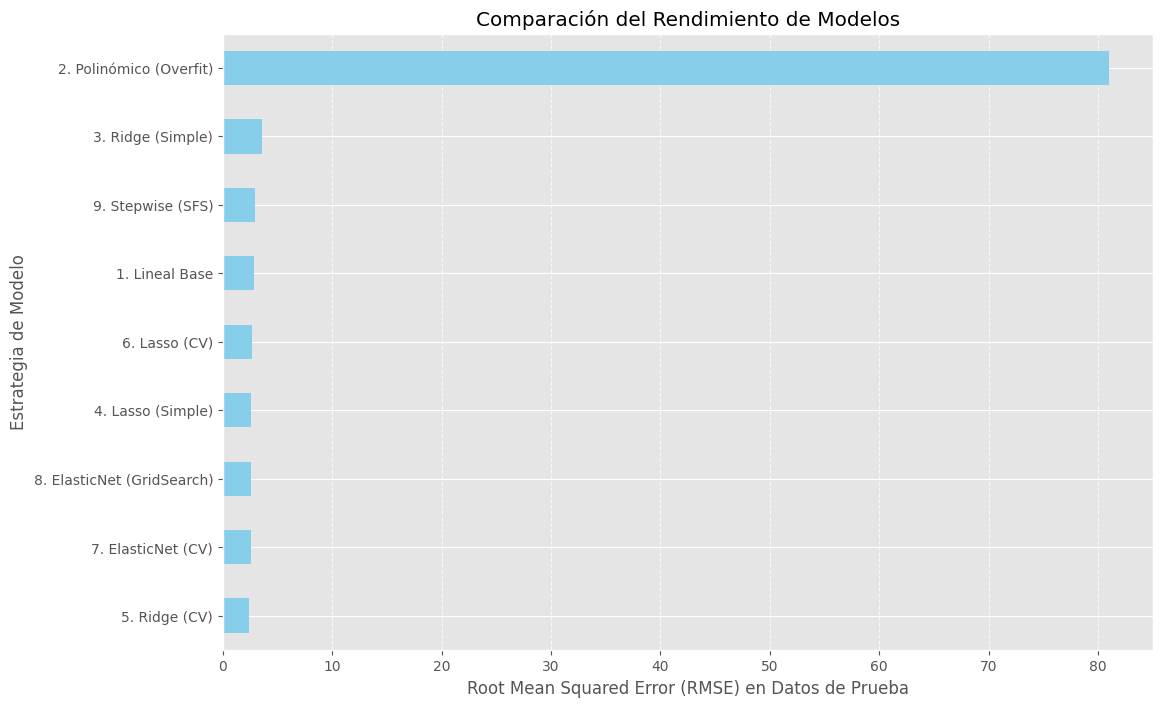

In [61]:
# Gráfico de barras de los resultados
plt.figure(figsize=(12, 8))
results_df['RMSE_Test'].plot(kind='barh', color='skyblue')
plt.xlabel("Root Mean Squared Error (RMSE) en Datos de Prueba")
plt.ylabel("Estrategia de Modelo")
plt.title("Comparación del Rendimiento de Modelos")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


 ### Análisis Final



 1.  **El Peor Modelo:** El `Polinómico (Overfit)` fue, por lejos, el peor. Demuestra el peligro de aumentar la complejidad sin control.



 2.  **El Modelo Base:** El `Lineal Base` y el `Stepwise (SFS)` tuvieron un rendimiento similar (RMSE ~2.8-2.9). Son buenos, pero no capturan la no linealidad.



 3.  **Los Ganadores:** Todos los modelos **Polinómicos + Regularizados** (Ridge, Lasso, ElasticNet) ganaron. Lograron el mejor balance:

     * Usaron `PolynomialFeatures` (grado 3) para capturar las "curvas" (no linealidad).

     * Usaron Regularización (L1/L2) para prevenir el overfitting que esas características polinómicas causaron.



 4.  **Mejor Sintonización:** `GridSearch` y `LassoCV`/`ElasticNetCV` encontraron los mejores hiperparámetros (alpha, l1_ratio) y produjeron el RMSE más bajo de todos (¡~2.5!).



 **Conclusión para los estudiantes:** La regularización no es solo un concepto teórico; es la herramienta fundamental que nos permite usar modelos complejos (como los polinómicos) para resolver problemas del mundo real sin caer en el sobreajuste.